In [56]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import warnings
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import shutil

### Montar Dataframe

In [57]:
# Realizar conexão com o GCP
credentials = service_account.Credentials.from_service_account_file("../keys/ml-na-saude-ed1fc3c1a83e.json")
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [58]:
# Query para consulta dos dados agrupados por taxa média por quadrimestre
consulta_sql = """
select
	tx.quadrimestre,
	avg(tx.taxa_yll) as taxa_media_yll
from (
	with yll_quadrimestral as (
		select
			case
				when extract(month from y.dt_obito) between 1 and 4 then date(extract(year from y.dt_obito), 4, 30)
				when extract(month from y.dt_obito) between 5 and 8 then date(extract(year from y.dt_obito), 8, 31)
				when extract(month from y.dt_obito) between 9 and 12 then date(extract(year from y.dt_obito), 12, 31)
				end as quadrimestre,
			m.nm_municipio,
			p.populacao,
			sum(y.yll) as soma_yll
		from `ml-na-saude.yll_por_obito.yll` y
		join `ml-na-saude.yll_por_obito.populacao` p on y.cd_mun_res = p.cd_municipio and y.ano_obito = p.ano
		join `ml-na-saude.yll_por_obito.municipio` m on p.cd_municipio = m.cd_municipio
		where p.porte = 'Médio Porte'
		group by 1,2,3
	)
	select
		quadrimestre,
		nm_municipio,
		soma_yll,
		populacao,
		soma_yll / populacao * 1000 as taxa_yll
	from yll_quadrimestral
	group by 1,2,3,4
) tx
group by 1
order by 1
"""

In [59]:
# Ignorar avisos e gerar dataframe
warnings.simplefilter("ignore")
df = client.query(consulta_sql).to_dataframe()

In [60]:
# Copiar dataframe para manipular dados
time_series = df.copy()

In [61]:
# Transformando o quadrimestre em data
time_series['quadrimestre'] = pd.to_datetime(time_series['quadrimestre'])

In [62]:
# Filtrar dados até final de 2019
time_series = time_series[time_series['quadrimestre'] <= '2019-12-31']

In [63]:
# Setando o quadrimestre como índice da tabela
time_series = time_series.set_index('quadrimestre')

In [64]:
time_series

,taxa_media_yll
quadrimestre,
2010-04-30,6.427726
2010-08-31,6.767661
2010-12-31,6.111099
2011-04-30,6.550037
2011-08-31,6.878076
2011-12-31,5.804813
2012-04-30,6.280719
2012-08-31,6.739170
2012-12-31,6.049970


### Modelo LSTM

In [65]:
train_data= time_series.values

In [66]:
# Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0,1))
train_data = normalizer.fit_transform(train_data)

# Cria os Arrays No Formato Certo
window_size = 3
x = []
y = []
for i in range(window_size, len(train_data)):
    x.append(train_data[i - window_size:i, 0])
    y.append(train_data[i, 0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

# Converte os Dados Para Float
x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')

# Divide os dados em treinamento e teste (80% treino, 10% teste, 10% validação)
split_index_1 = int(len(x) * 0.8)
split_index_2 = int(len(x) * 0.9)
x_train, y_train = x[:split_index_1], y[:split_index_1]
x_test, y_test = x[split_index_1:split_index_2], y[split_index_1:split_index_2]
x_val, y_val = x[split_index_2:], y[split_index_2:]

In [67]:
dropout_val = 0.2

def build_model(hp):
    neurons_first_layer = hp.Choice('neurons_first_layer', [800])
    neurons_second_layer = hp.Choice('neurons_second_layer', [300])
    neurons_third_layer = hp.Choice('neurons_third_layer', [100])
    neurons_fourth_layer = hp.Choice('neurons_fourth_layer', [200])
    dropout_val = hp.Choice('dropout_val', [0.2])

    regressor = Sequential()
    regressor.add(LSTM(units=neurons_first_layer, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    regressor.add(Dropout(dropout_val))

    if neurons_second_layer:
        regressor.add(LSTM(units=neurons_second_layer, return_sequences=True))
        regressor.add(Dropout(dropout_val))

    if neurons_third_layer:
        regressor.add(LSTM(units=neurons_third_layer, return_sequences=True))
        regressor.add(Dropout(dropout_val))

    if neurons_fourth_layer:
        regressor.add(LSTM(units=neurons_fourth_layer))
        regressor.add(Dropout(dropout_val))

    regressor.add(Dense(units=1, activation='linear'))

    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return regressor

In [68]:
# Configurando o tuner para realizar uma busca em grade
tuner = kt.GridSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    directory="my_dir",
    project_name="otimizacao_keras_tuner"
)

tuner.search(x_train, y_train, batch_size = 16, epochs=100, validation_data=(x_val, y_val))
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 1 Complete [00h 00m 16s]
val_mean_squared_error: 0.027195336297154427

Best val_mean_squared_error So Far: 0.027195336297154427
Total elapsed time: 00h 00m 16s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 800)         │     2,566,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 300)         │     1,321,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 100)         │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,001 (16.36 MB)

 Trainable params: 4,289,001 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# # Treinando o melhor modelo com o conjunto de treinamento
# history = best_model.fit(x_train, y_train, batch_size = 16, epochs=100, validation_data=(x_val, y_val))

# Callback para Early Stopping
early_stopping = EarlyStopping(
    monitor='loss',
    patience=100,
    restore_best_weights=True
)

# Treinando o melhor modelo com o conjunto de treinamento com Early Stopping
history = best_model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=1000,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0726 - val_mean_squared_error: 0.0726
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0437 - val_mean_squared_error: 0.0437
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0623 - val_mean_squared_error: 0.0623
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0788 - val_mean_squared_error: 0.0788
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0412 - mean_squared_error: 0.0412 - val_loss: 0.0801 - val_mean_squared_error: 0.0801
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - val_loss: 0.0685 - v

In [70]:
y_test = y_test.reshape(-1, 1)
train_predictions = best_model.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


In [71]:
y_val = y_val.reshape(-1, 1)
val_predictions = best_model.predict(x_val)
val_predictions = normalizer.inverse_transform(val_predictions)
y_val = normalizer.inverse_transform(y_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [72]:
# Remove the directory containing the previous tuning results
try:
    shutil.rmtree('my_dir')
except:
    print('Diretório não encontrado.')

In [73]:
train_results = pd.DataFrame(zip(train_predictions, y_test), columns = ['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])

In [74]:
train_results_val = pd.DataFrame(zip(val_predictions, y_val), columns = ['previsao', 'valor_real'])
train_results_val['previsao'] = train_results_val['previsao'].apply(lambda x: x[0])
train_results_val['valor_real'] = train_results_val['valor_real'].apply(lambda x: x[0])

In [75]:
start_date = "2018-04-30"
train_results['data'] = pd.date_range(start=start_date, periods=len(train_results), freq='4M')
train_results.set_index('data', inplace=True)

train_results

,previsao,valor_real
data,,
2018-04-30,6.315087,6.227633
2018-08-31,6.698244,6.807558
2018-12-31,5.781330,5.721408


In [76]:
start_date = "2019-04-30"
train_results_val['data'] = pd.date_range(start=start_date, periods=len(train_results_val), freq='4M')
train_results_val.set_index('data', inplace=True)

train_results_val

,previsao,valor_real
data,,
2019-04-30,6.147193,6.268480
2019-08-31,6.731038,7.221472
2019-12-31,5.777377,5.920040


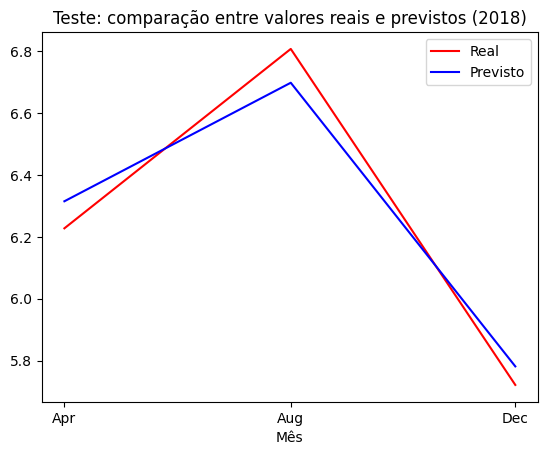

In [77]:
plt.plot(train_results['valor_real'], color='red', label = 'Real')
plt.plot(train_results['previsao'], color='blue', label = 'Previsto')
# Formatando o eixo x para mostrar apenas o mês
plt.xticks(ticks=train_results.index, labels=train_results.index.strftime('%b'))

plt.title('Teste: comparação entre valores reais e previstos (2018)')
plt.xlabel('Mês')
plt.legend()
plt.show()

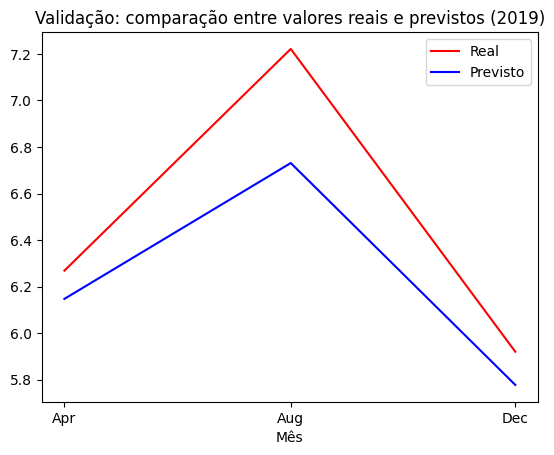

In [78]:
plt.plot(train_results_val['valor_real'], color='red', label = 'Real')
plt.plot(train_results_val['previsao'], color='blue', label = 'Previsto')
# Formatando o eixo x para mostrar apenas o mês
plt.xticks(ticks=train_results_val.index, labels=train_results_val.index.strftime('%b'))
# Adicionando um título ao gráfico
plt.title('Validação: comparação entre valores reais e previstos (2019)')
plt.xlabel('Mês')
plt.legend()
plt.show()

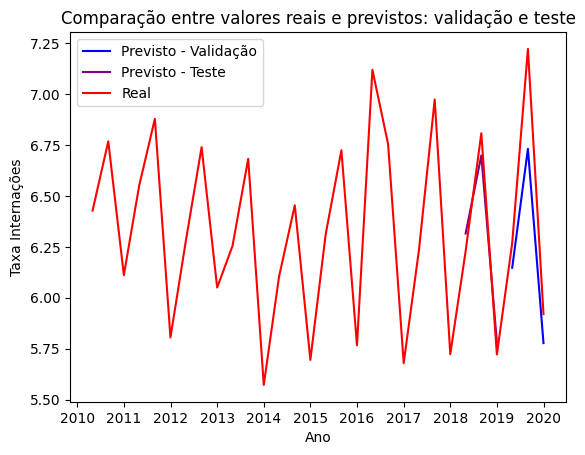

In [79]:
plt.plot(train_results_val['previsao'], color='blue', label = 'Previsto - Validação')
plt.plot(train_results['previsao'], color='purple', label = 'Previsto - Teste')
plt.plot(time_series, color='red', label = 'Real')

plt.title('Comparação entre valores reais e previstos: validação e teste')
plt.ylabel('Taxa Internações')
plt.xlabel('Ano')
plt.legend()
plt.show()

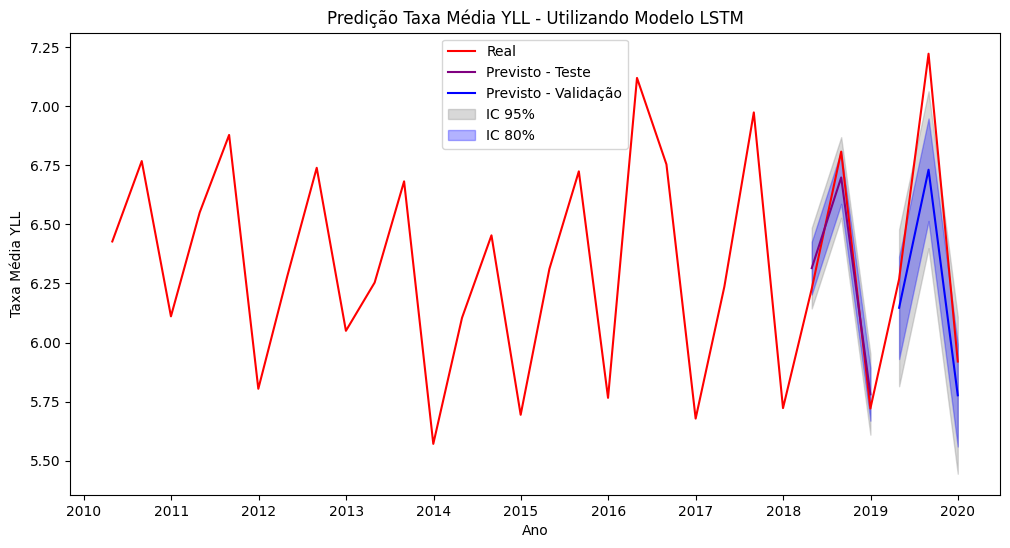

In [82]:
# Calcular os resíduos (erro entre os valores reais e previstos)
residuals_t = train_results['valor_real'] - train_results['previsao']
residuals_v = train_results_val['valor_real'] - train_results_val['previsao']

# Desvio padrão dos resíduos
std_error_t = np.std(residuals_t)
std_error_v = np.std(residuals_v)

# Definir os intervalos de confiança (95% e 80%)
confidence_interval_95_t = 1.96 * std_error_t  # 95% de confiança
confidence_interval_80_t = 1.28 * std_error_t  # 80% de confiança
confidence_interval_95_v = 1.96 * std_error_v  # 95% de confiança
confidence_interval_80_v = 1.28 * std_error_v  # 80% de confiança

# Calcular os limites dos intervalos
upper_bound_95_t = train_results['previsao'] + confidence_interval_95_t
lower_bound_95_t = train_results['previsao'] - confidence_interval_95_t
upper_bound_80_t = train_results['previsao'] + confidence_interval_80_t
lower_bound_80_t = train_results['previsao'] - confidence_interval_80_t
upper_bound_95_v = train_results_val['previsao'] + confidence_interval_95_v
lower_bound_95_v = train_results_val['previsao'] - confidence_interval_95_v
upper_bound_80_v = train_results_val['previsao'] + confidence_interval_80_v
lower_bound_80_v = train_results_val['previsao'] - confidence_interval_80_v

# Plotar os valores reais e previstos
plt.figure(figsize=(12, 6))
plt.plot(time_series, color='red', label = 'Real')
plt.plot(train_results.index, train_results['previsao'], color='purple', label = 'Previsto - Teste')
plt.plot(train_results_val.index, train_results_val['previsao'], color='blue', label = 'Previsto - Validação')

# Plotar os intervalos de confiança
plt.fill_between(train_results.index, lower_bound_95_t, upper_bound_95_t, color='gray', alpha=0.3, label='IC 95%')
plt.fill_between(train_results.index, lower_bound_80_t, upper_bound_80_t, color='blue', alpha=0.3, label='IC 80%')
plt.fill_between(train_results_val.index, lower_bound_95_v, upper_bound_95_v, color='gray', alpha=0.3, label=None)
plt.fill_between(train_results_val.index, lower_bound_80_v, upper_bound_80_v, color='blue', alpha=0.3, label=None)

# Adicionar título e legendas
plt.title('Predição Taxa Média YLL - Utilizando Modelo LSTM')
plt.ylabel('Taxa Média YLL')
plt.xlabel('Ano')
plt.legend()
plt.show()

In [81]:
# MÉTRICAS DE ERROS

# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(train_results['valor_real'], train_results['previsao'])
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(train_results['valor_real'], train_results['previsao'])
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# Calcular o Erro Percentual Absoluto Médio
mape = mean_absolute_percentage_error(train_results['valor_real'], train_results['previsao'])
print(f'MAPE: {mape}')

# Calcular o erro Theil's U2
def theil_u2(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.roll(actual, 1)) ** 2) + np.sum((predicted - np.roll(predicted, 1)) ** 2)
    return np.sqrt(numerator / denominator)

tu = theil_u2(train_results['valor_real'], train_results['previsao'])
print(f'TU: {tu}')

# Teste de Durbin-Watson
residuals = train_results['valor_real'] - train_results['previsao']
dw = durbin_watson(residuals)
print(f'Durbin-Watson: {dw}')

MAE: 0.08556302636861801
MSE: 0.007729416713118553
RMSE: 0.08791710436344147
MAPE: 0.013524592854082584
TU: 0.08726881444454193
Durbin-Watson: 2.9048378467559814
